In [1]:
import sys
import os

sys.path.append(os.path.abspath("../"))

In [2]:
# Function to calculate MAPE manually for evaluation
def calculate_mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error
    
    Parameters:
    -----------
    y_true : array-like
        Actual values
    y_pred : array-like
        Predicted values
        
    Returns:
    --------
    mape : float
        Mean Absolute Percentage Error value
    """
    # Avoid division by zero
    epsilon = 1e-7
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = np.abs(y_true) > epsilon
    
    # Apply mask to avoid division by very small values
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
    return mape

In [3]:
# Improved data preprocessing with lag features
def add_lag_features(df, col_name, lag_list):
    """
    Add lag features to a DataFrame for a specified column
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input DataFrame
    col_name : str
        Column name to create lag features for
    lag_list : list
        List of lag values to create
        
    Returns:
    --------
    df : pandas DataFrame
        DataFrame with lag features added
    """
    for lag in lag_list:
        df[f'{col_name}_lag_{lag}'] = df[col_name].shift(lag)
    
    return df

In [4]:
# Enhanced feature engineering function
def enhance_features(df):
    """
    Add additional engineered features to improve model accuracy
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input DataFrame with datetime index
        
    Returns:
    --------
    df : pandas DataFrame
        Enhanced DataFrame with new features
    """
    # Add cyclical time features
    # df = add_cyclical_time_features(df)
    
    # Add lag features for demand (24h, 48h, 168h/week ago)
    df = add_lag_features(df, 'demand', [24, 48, 168])
    
    # Add lag features for temperature
    df = add_lag_features(df, 'temperature_2m', [24, 48])
    
    # Add rolling statistics for demand
    df['demand_rolling_mean_24h'] = df['demand'].rolling(window=24).mean()
    df['demand_rolling_std_24h'] = df['demand'].rolling(window=24).std()
    
    # Add rolling statistics for temperature
    df['temp_rolling_mean_24h'] = df['temperature_2m'].rolling(window=24).mean()
    
    # Add demand-temperature interaction features
    df['demand_temp_interaction'] = df['demand'] * df['temperature_2m']
    
    # Calculate first-order differences (rate of change)
    df['demand_diff'] = df['demand'].diff()
    df['temp_diff'] = df['temperature_2m'].diff()
    
    # Add is_weekend feature
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    
    # Add is_holiday feature (simplified version - you would need actual holiday data)
    # This is a placeholder - replace with actual holiday data if available
    df['is_holiday'] = 0
    
    return df

In [5]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import register_keras_serializable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from pathlib import Path
import pickle
from sklearn.preprocessing import MinMaxScaler
import src.component.feature_group_config as config

2025-04-21 17:36:36.212524: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-21 17:36:36.217939: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-21 17:36:36.236398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745256996.261145  163599 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745256996.270620  163599 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745256996.293878  163599 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [6]:
# Connect to the project
import hopsworks
project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME,
    api_key_value=config.HOPSWORKS_API_KEY
)

# Connect to Hopsworks feature store
fs = project.get_feature_store(name='mix_featurestore')
fg = fs.get_feature_group('electricity_demand_feature_group', version=3)

2025-04-21 17:36:45,314 INFO: Initializing external client
2025-04-21 17:36:45,316 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-04-21 17:36:46,030 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1222815


In [7]:
# Read data from feature group
df = fg.read()
df.info()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220473 entries, 0 to 220472
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype                  
---  ------           --------------   -----                  
 0   date             220473 non-null  datetime64[us, Etc/UTC]
 1   sub_region_code  220473 non-null  int64                  
 2   demand           220473 non-null  object                 
 3   temperature_2m   220473 non-null  float32                
 4   seconds          220473 non-null  int64                  
dtypes: datetime64[us, Etc/UTC](1), float32(1), int64(2), object(1)
memory usage: 7.6+ MB


In [8]:
df.head()

,date,sub_region_code,demand,temperature_2m,seconds
0,2023-03-22 02:00:00+00:00,6,1039,0.6085,1679450400000
1,2023-03-24 02:00:00+00:00,9,5309,3.3585,1679623200000
2,2024-03-30 22:00:00+00:00,3,625,2.7085,1711836000000
3,2023-03-29 22:00:00+00:00,9,5973,3.5085,1680127200000
4,2023-08-31 21:00:00+00:00,4,821,13.3085,1693515600000


In [9]:
data = df.copy()

In [10]:
# View unique sub-regions
sub_region_unique = data["sub_region_code"].unique()
print("Unique sub-regions:", sub_region_unique)

Unique sub-regions: [ 6  9  3  4 10  7  5  0  8  1  2]


In [11]:
# Filter for a specific sub-region
df_sub_0 = data[data["sub_region_code"] == 0]
df_sub_0.head()

,date,sub_region_code,demand,temperature_2m,seconds
14,2024-02-01 11:00:00+00:00,0,1742,5.208500,1706785200000
25,2023-10-19 02:00:00+00:00,0,1749,4.058500,1697680800000
44,2025-03-20 09:00:00+00:00,0,1707,10.408501,1742461200000
91,2024-10-19 13:00:00+00:00,0,1570,17.158501,1729342800000
96,2023-09-14 16:00:00+00:00,0,1623,15.958500,1694707200000


In [12]:
# Sort by date
df_sub_0.sort_values(by=['date'], inplace=True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
# Keep temperature this time, only drop sub_region_code
df_sub_0.drop(['sub_region_code'], axis=1, inplace=True)
df_sub_0.iloc[:20]

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,demand,temperature_2m,seconds
30852,2023-01-01 04:00:00+00:00,1571,7.808500,1672545600000
150947,2023-01-01 05:00:00+00:00,1497,8.008500,1672549200000
166007,2023-01-01 06:00:00+00:00,1446,7.708500,1672552800000
29110,2023-01-01 07:00:00+00:00,1418,8.058500,1672556400000
138846,2023-01-01 08:00:00+00:00,1406,9.058500,1672560000000
214367,2023-01-01 09:00:00+00:00,1395,10.108500,1672563600000
21153,2023-01-01 10:00:00+00:00,1396,10.308500,1672567200000
193652,2023-01-01 11:00:00+00:00,1422,10.258500,1672570800000
111260,2023-01-01 12:00:00+00:00,1469,11.708500,1672574400000
174300,2023-01-01 13:00:00+00:00,1519,11.008500,1672578000000


In [14]:
df = df_sub_0.copy()

In [15]:
# Convert types and set index
df['demand'] = pd.to_numeric(df['demand'])
df['temperature_2m'] = pd.to_numeric(df['temperature_2m'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20043 entries, 2023-01-01 04:00:00+00:00 to 2025-04-15 07:00:00+00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   demand          20043 non-null  int64  
 1   temperature_2m  20043 non-null  float32
 2   seconds         20043 non-null  int64  
dtypes: float32(1), int64(2)
memory usage: 548.1 KB


In [16]:
df

,demand,temperature_2m,seconds
date,,,
2023-01-01 04:00:00+00:00,1571,7.8085,1672545600000
2023-01-01 05:00:00+00:00,1497,8.0085,1672549200000
2023-01-01 06:00:00+00:00,1446,7.7085,1672552800000
2023-01-01 07:00:00+00:00,1418,8.0585,1672556400000
2023-01-01 08:00:00+00:00,1406,9.0585,1672560000000
...,...,...,...
2025-04-15 03:00:00+00:00,1613,4.9085,1744686000000
2025-04-15 04:00:00+00:00,1536,5.5585,1744689600000
2025-04-15 05:00:00+00:00,1477,5.7085,1744693200000


In [17]:
# Function to add cyclical time features
def add_cyclical_time_features(df):
    # Ensure the index is in datetime format
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Extract time components
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek  # 0 is Monday, 6 is Sunday
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    
    # Create cyclical features
    # Hours go from 0 to 23
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Days of week go from 0 to 6
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Drop the original time columns since we have the cyclical versions
    df.drop(['hour', 'day_of_week'], axis=1, inplace=True)
    
    return df

In [18]:
# %%
# Add cyclical time features to the dataframe
df = add_cyclical_time_features(df)
df.head()

,demand,temperature_2m,seconds,day_of_year,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
date,,,,,,,,,
2023-01-01 04:00:00+00:00,1571,7.8085,1672545600000,1,1,0.866025,5.000000e-01,-0.781831,0.62349
2023-01-01 05:00:00+00:00,1497,8.0085,1672549200000,1,1,0.965926,2.588190e-01,-0.781831,0.62349
2023-01-01 06:00:00+00:00,1446,7.7085,1672552800000,1,1,1.000000,6.123234e-17,-0.781831,0.62349
2023-01-01 07:00:00+00:00,1418,8.0585,1672556400000,1,1,0.965926,-2.588190e-01,-0.781831,0.62349
2023-01-01 08:00:00+00:00,1406,9.0585,1672560000000,1,1,0.866025,-5.000000e-01,-0.781831,0.62349


In [19]:
# Configure matplotlib
import matplotlib as mpl
from cycler import cycler

colors = cycler(color=plt.get_cmap("tab10").colors)

mpl.style.use("ggplot")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "lightgray"
mpl.rcParams["axes.prop_cycle"] = colors
mpl.rcParams["axes.linewidth"] = 1
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

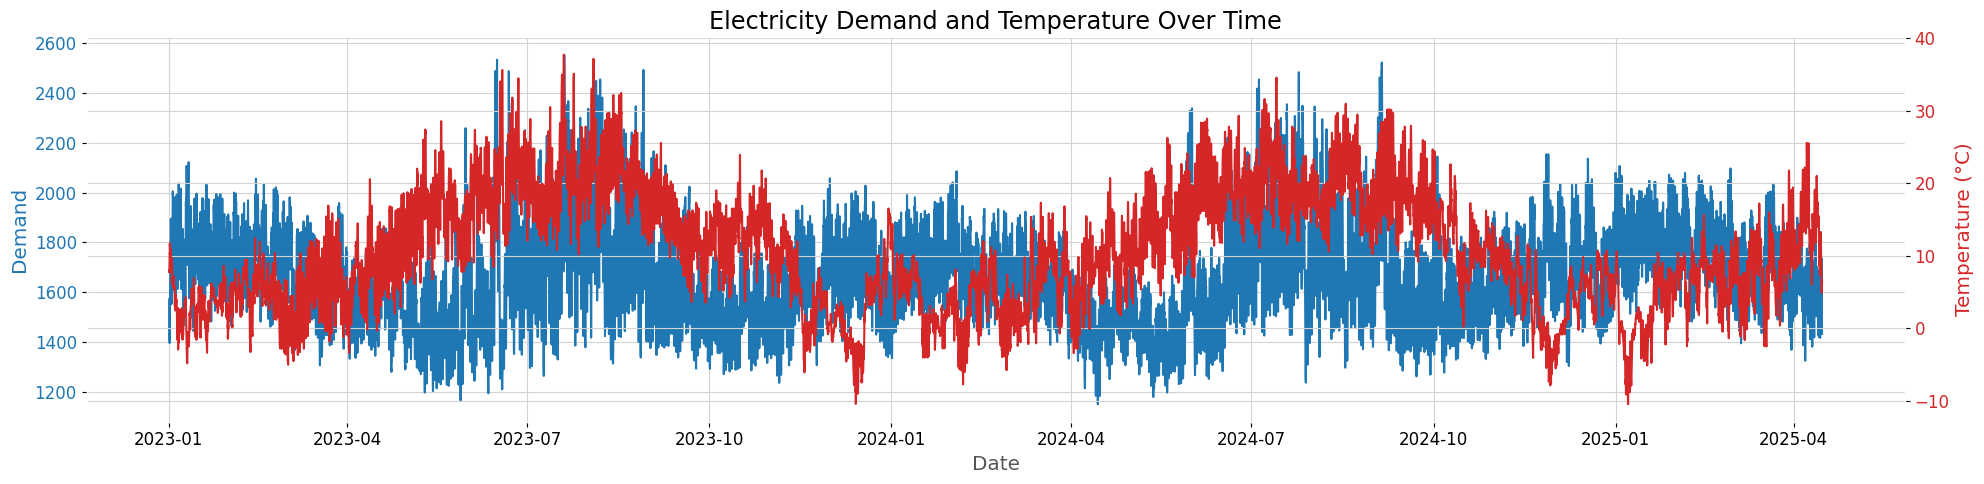

In [20]:
# Plot demand and temperature data
fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('Demand', color='tab:blue')
ax1.plot(df.index, df['demand'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Temperature (°C)', color='tab:red')
ax2.plot(df.index, df['temperature_2m'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Electricity Demand and Temperature Over Time')
fig.tight_layout()
plt.show()

In [21]:
df = enhance_features(df)
df.dropna(inplace=True)  # Drop rows with NaN values from lag features
df

,demand,temperature_2m,seconds,day_of_year,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,demand_lag_24,...,temperature_2m_lag_24,temperature_2m_lag_48,demand_rolling_mean_24h,demand_rolling_std_24h,temp_rolling_mean_24h,demand_temp_interaction,demand_diff,temp_diff,is_weekend,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2023-01-08 04:00:00+00:00,1684,-0.8415,1673150400000,8,1,0.866025,5.000000e-01,-0.781831,0.62349,1798.0,...,0.3585,-1.3915,1725.083333,73.709722,0.068917,-1417.085974,-59.0,0.55,1,0
2023-01-08 05:00:00+00:00,1601,-0.9415,1673154000000,8,1,0.965926,2.588190e-01,-0.781831,0.62349,1713.0,...,0.4085,-0.9915,1720.416667,77.932477,0.012667,-1507.341513,-83.0,-0.10,1,0
2023-01-08 06:00:00+00:00,1536,-0.8415,1673157600000,8,1,1.000000,6.123234e-17,-0.781831,0.62349,1655.0,...,0.0585,-0.7915,1715.458333,85.676327,-0.024833,-1292.543976,-65.0,0.10,1,0
2023-01-08 07:00:00+00:00,1506,-0.4415,1673161200000,8,1,0.965926,-2.588190e-01,-0.781831,0.62349,1637.0,...,-0.5915,-0.7415,1710.000000,94.600303,-0.018583,-664.899012,-30.0,0.40,1,0
2023-01-08 08:00:00+00:00,1481,-0.0415,1673164800000,8,1,0.866025,-5.000000e-01,-0.781831,0.62349,1616.0,...,-0.1915,-0.1915,1704.375000,103.981107,-0.012333,-61.461503,-25.0,0.40,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-15 03:00:00+00:00,1613,4.9085,1744686000000,105,4,0.707107,7.071068e-01,0.781831,0.62349,1551.0,...,7.8085,16.7085,1561.875000,93.890923,9.568917,7917.410045,-72.0,0.00,0,0
2025-04-15 04:00:00+00:00,1536,5.5585,1744689600000,105,4,0.866025,5.000000e-01,0.781831,0.62349,1487.0,...,7.6585,16.2085,1563.916667,92.717390,9.481417,8537.855713,-77.0,0.65,0,0
2025-04-15 05:00:00+00:00,1477,5.7085,1744693200000,105,4,0.965926,2.588190e-01,0.781831,0.62349,1457.0,...,7.3585,15.3585,1564.750000,91.799995,9.412667,8431.454365,-59.0,0.15,0,0


In [22]:
df.columns

Index(['demand', 'temperature_2m', 'seconds', 'day_of_year', 'month',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'demand_lag_24', 'demand_lag_48', 'demand_lag_168',
       'temperature_2m_lag_24', 'temperature_2m_lag_48',
       'demand_rolling_mean_24h', 'demand_rolling_std_24h',
       'temp_rolling_mean_24h', 'demand_temp_interaction', 'demand_diff',
       'temp_diff', 'is_weekend', 'is_holiday'],
      dtype='object')

In [23]:
df_rt = df.loc['2023-01-01 07:00:00+00:00':'2024-12-31 07:00:00+00:00']
df_rt

,demand,temperature_2m,seconds,day_of_year,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,demand_lag_24,...,temperature_2m_lag_24,temperature_2m_lag_48,demand_rolling_mean_24h,demand_rolling_std_24h,temp_rolling_mean_24h,demand_temp_interaction,demand_diff,temp_diff,is_weekend,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2023-01-08 04:00:00+00:00,1684,-0.8415,1673150400000,8,1,0.866025,5.000000e-01,-0.781831,0.62349,1798.0,...,0.3585,-1.3915,1725.083333,73.709722,0.068917,-1417.085974,-59.0,0.55,1,0
2023-01-08 05:00:00+00:00,1601,-0.9415,1673154000000,8,1,0.965926,2.588190e-01,-0.781831,0.62349,1713.0,...,0.4085,-0.9915,1720.416667,77.932477,0.012667,-1507.341513,-83.0,-0.10,1,0
2023-01-08 06:00:00+00:00,1536,-0.8415,1673157600000,8,1,1.000000,6.123234e-17,-0.781831,0.62349,1655.0,...,0.0585,-0.7915,1715.458333,85.676327,-0.024833,-1292.543976,-65.0,0.10,1,0
2023-01-08 07:00:00+00:00,1506,-0.4415,1673161200000,8,1,0.965926,-2.588190e-01,-0.781831,0.62349,1637.0,...,-0.5915,-0.7415,1710.000000,94.600303,-0.018583,-664.899012,-30.0,0.40,1,0
2023-01-08 08:00:00+00:00,1481,-0.0415,1673164800000,8,1,0.866025,-5.000000e-01,-0.781831,0.62349,1616.0,...,-0.1915,-0.1915,1704.375000,103.981107,-0.012333,-61.461503,-25.0,0.40,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 03:00:00+00:00,1796,2.9585,1735614000000,366,12,0.707107,7.071068e-01,0.781831,0.62349,1730.0,...,4.6585,3.7585,1693.000000,136.132927,5.033500,5313.466264,-49.0,-0.85,0,0
2024-12-31 04:00:00+00:00,1734,2.6085,1735617600000,366,12,0.866025,5.000000e-01,0.781831,0.62349,1685.0,...,4.4085,3.4085,1695.041667,136.374956,4.958500,4523.139007,-62.0,-0.35,0,0
2024-12-31 05:00:00+00:00,1672,2.5585,1735621200000,366,12,0.965926,2.588190e-01,0.781831,0.62349,1630.0,...,3.9085,3.1085,1696.791667,135.772181,4.902250,4277.812086,-62.0,-0.05,0,0


In [24]:
df

,demand,temperature_2m,seconds,day_of_year,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,demand_lag_24,...,temperature_2m_lag_24,temperature_2m_lag_48,demand_rolling_mean_24h,demand_rolling_std_24h,temp_rolling_mean_24h,demand_temp_interaction,demand_diff,temp_diff,is_weekend,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2023-01-08 04:00:00+00:00,1684,-0.8415,1673150400000,8,1,0.866025,5.000000e-01,-0.781831,0.62349,1798.0,...,0.3585,-1.3915,1725.083333,73.709722,0.068917,-1417.085974,-59.0,0.55,1,0
2023-01-08 05:00:00+00:00,1601,-0.9415,1673154000000,8,1,0.965926,2.588190e-01,-0.781831,0.62349,1713.0,...,0.4085,-0.9915,1720.416667,77.932477,0.012667,-1507.341513,-83.0,-0.10,1,0
2023-01-08 06:00:00+00:00,1536,-0.8415,1673157600000,8,1,1.000000,6.123234e-17,-0.781831,0.62349,1655.0,...,0.0585,-0.7915,1715.458333,85.676327,-0.024833,-1292.543976,-65.0,0.10,1,0
2023-01-08 07:00:00+00:00,1506,-0.4415,1673161200000,8,1,0.965926,-2.588190e-01,-0.781831,0.62349,1637.0,...,-0.5915,-0.7415,1710.000000,94.600303,-0.018583,-664.899012,-30.0,0.40,1,0
2023-01-08 08:00:00+00:00,1481,-0.0415,1673164800000,8,1,0.866025,-5.000000e-01,-0.781831,0.62349,1616.0,...,-0.1915,-0.1915,1704.375000,103.981107,-0.012333,-61.461503,-25.0,0.40,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-15 03:00:00+00:00,1613,4.9085,1744686000000,105,4,0.707107,7.071068e-01,0.781831,0.62349,1551.0,...,7.8085,16.7085,1561.875000,93.890923,9.568917,7917.410045,-72.0,0.00,0,0
2025-04-15 04:00:00+00:00,1536,5.5585,1744689600000,105,4,0.866025,5.000000e-01,0.781831,0.62349,1487.0,...,7.6585,16.2085,1563.916667,92.717390,9.481417,8537.855713,-77.0,0.65,0,0
2025-04-15 05:00:00+00:00,1477,5.7085,1744693200000,105,4,0.965926,2.588190e-01,0.781831,0.62349,1457.0,...,7.3585,15.3585,1564.750000,91.799995,9.412667,8431.454365,-59.0,0.15,0,0


In [25]:
total_rows = len(df)
total_rows

19875

In [26]:
# Split data into train, validation, and test sets
total_rows = len(df)
train_size = 17356
val_size = int(0.15 * total_rows)
test_size = total_rows - (0.7 * total_rows) - val_size

train_set = df[:train_size]
val_set = df[int(0.7 * total_rows): int(0.7 * total_rows) + val_size]
test_set = df[int(0.7 * total_rows) + val_size:]

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 17356
Validation set size: 2981
Test set size: 2982


In [27]:
train_set

,demand,temperature_2m,seconds,day_of_year,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,demand_lag_24,...,temperature_2m_lag_24,temperature_2m_lag_48,demand_rolling_mean_24h,demand_rolling_std_24h,temp_rolling_mean_24h,demand_temp_interaction,demand_diff,temp_diff,is_weekend,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2023-01-08 04:00:00+00:00,1684,-0.8415,1673150400000,8,1,0.866025,5.000000e-01,-0.781831,0.62349,1798.0,...,0.3585,-1.3915,1725.083333,73.709722,0.068917,-1417.085974,-59.0,0.55,1,0
2023-01-08 05:00:00+00:00,1601,-0.9415,1673154000000,8,1,0.965926,2.588190e-01,-0.781831,0.62349,1713.0,...,0.4085,-0.9915,1720.416667,77.932477,0.012667,-1507.341513,-83.0,-0.10,1,0
2023-01-08 06:00:00+00:00,1536,-0.8415,1673157600000,8,1,1.000000,6.123234e-17,-0.781831,0.62349,1655.0,...,0.0585,-0.7915,1715.458333,85.676327,-0.024833,-1292.543976,-65.0,0.10,1,0
2023-01-08 07:00:00+00:00,1506,-0.4415,1673161200000,8,1,0.965926,-2.588190e-01,-0.781831,0.62349,1637.0,...,-0.5915,-0.7415,1710.000000,94.600303,-0.018583,-664.899012,-30.0,0.40,1,0
2023-01-08 08:00:00+00:00,1481,-0.0415,1673164800000,8,1,0.866025,-5.000000e-01,-0.781831,0.62349,1616.0,...,-0.1915,-0.1915,1704.375000,103.981107,-0.012333,-61.461503,-25.0,0.40,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 03:00:00+00:00,1796,2.9585,1735614000000,366,12,0.707107,7.071068e-01,0.781831,0.62349,1730.0,...,4.6585,3.7585,1693.000000,136.132927,5.033500,5313.466264,-49.0,-0.85,0,0
2024-12-31 04:00:00+00:00,1734,2.6085,1735617600000,366,12,0.866025,5.000000e-01,0.781831,0.62349,1685.0,...,4.4085,3.4085,1695.041667,136.374956,4.958500,4523.139007,-62.0,-0.35,0,0
2024-12-31 05:00:00+00:00,1672,2.5585,1735621200000,366,12,0.965926,2.588190e-01,0.781831,0.62349,1630.0,...,3.9085,3.1085,1696.791667,135.772181,4.902250,4277.812086,-62.0,-0.05,0,0


In [28]:
# Scale features (exclude binary features like is_weekend, is_holiday)
binary_features = ['is_weekend', 'is_holiday']
numerical_features = [col for col in df.columns if col not in binary_features]
scalers = {}

In [29]:
numerical_features

['demand',
 'temperature_2m',
 'seconds',
 'day_of_year',
 'month',
 'hour_sin',
 'hour_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'demand_lag_24',
 'demand_lag_48',
 'demand_lag_168',
 'temperature_2m_lag_24',
 'temperature_2m_lag_48',
 'demand_rolling_mean_24h',
 'demand_rolling_std_24h',
 'temp_rolling_mean_24h',
 'demand_temp_interaction',
 'demand_diff',
 'temp_diff']

In [30]:
from src.paths import MODELS_DIR

In [31]:
for feature in numerical_features:
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_set.loc[:, f'{feature}_scaled'] = scaler.fit_transform(train_set[[feature]])
    val_set.loc[:, f'{feature}_scaled'] = scaler.transform(val_set[[feature]])
    test_set.loc[:, f'{feature}_scaled'] = scaler.transform(test_set[[feature]])
    scalers[feature] = scaler

# Save all scalers
scalers_path = MODELS_DIR / 'enhanced_new/feature_scalers.pkl'
with open(scalers_path, 'wb') as f:
    pickle.dump(scalers, f)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [32]:
scalers

{'demand': MinMaxScaler(),
 'temperature_2m': MinMaxScaler(),
 'seconds': MinMaxScaler(),
 'day_of_year': MinMaxScaler(),
 'month': MinMaxScaler(),
 'hour_sin': MinMaxScaler(),
 'hour_cos': MinMaxScaler(),
 'day_of_week_sin': MinMaxScaler(),
 'day_of_week_cos': MinMaxScaler(),
 'demand_lag_24': MinMaxScaler(),
 'demand_lag_48': MinMaxScaler(),
 'demand_lag_168': MinMaxScaler(),
 'temperature_2m_lag_24': MinMaxScaler(),
 'temperature_2m_lag_48': MinMaxScaler(),
 'demand_rolling_mean_24h': MinMaxScaler(),
 'demand_rolling_std_24h': MinMaxScaler(),
 'temp_rolling_mean_24h': MinMaxScaler(),
 'demand_temp_interaction': MinMaxScaler(),
 'demand_diff': MinMaxScaler(),
 'temp_diff': MinMaxScaler()}

In [33]:
# Add binary features directly (no scaling needed)
for feature in binary_features:
    train_set[f'{feature}_scaled'] = train_set[feature]
    val_set[f'{feature}_scaled'] = val_set[feature]
    test_set[f'{feature}_scaled'] = test_set[feature]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [34]:
train_set.columns

Index(['demand', 'temperature_2m', 'seconds', 'day_of_year', 'month',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'demand_lag_24', 'demand_lag_48', 'demand_lag_168',
       'temperature_2m_lag_24', 'temperature_2m_lag_48',
       'demand_rolling_mean_24h', 'demand_rolling_std_24h',
       'temp_rolling_mean_24h', 'demand_temp_interaction', 'demand_diff',
       'temp_diff', 'is_weekend', 'is_holiday', 'demand_scaled',
       'temperature_2m_scaled', 'seconds_scaled', 'day_of_year_scaled',
       'month_scaled', 'hour_sin_scaled', 'hour_cos_scaled',
       'day_of_week_sin_scaled', 'day_of_week_cos_scaled',
       'demand_lag_24_scaled', 'demand_lag_48_scaled', 'demand_lag_168_scaled',
       'temperature_2m_lag_24_scaled', 'temperature_2m_lag_48_scaled',
       'demand_rolling_mean_24h_scaled', 'demand_rolling_std_24h_scaled',
       'temp_rolling_mean_24h_scaled', 'demand_temp_interaction_scaled',
       'demand_diff_scaled', 'temp_diff_scaled', 'is_wee

In [35]:
# Create feature and target columns - use all scaled features
feature_cols = [col for col in train_set.columns if col.endswith('_scaled')]
target_col = 'demand_scaled'

In [36]:
print(df.columns)
print(len(df.columns))

Index(['demand', 'temperature_2m', 'seconds', 'day_of_year', 'month',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'demand_lag_24', 'demand_lag_48', 'demand_lag_168',
       'temperature_2m_lag_24', 'temperature_2m_lag_48',
       'demand_rolling_mean_24h', 'demand_rolling_std_24h',
       'temp_rolling_mean_24h', 'demand_temp_interaction', 'demand_diff',
       'temp_diff', 'is_weekend', 'is_holiday'],
      dtype='object')
22


In [37]:
print(train_set.columns)
print(len(train_set.columns))

Index(['demand', 'temperature_2m', 'seconds', 'day_of_year', 'month',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'demand_lag_24', 'demand_lag_48', 'demand_lag_168',
       'temperature_2m_lag_24', 'temperature_2m_lag_48',
       'demand_rolling_mean_24h', 'demand_rolling_std_24h',
       'temp_rolling_mean_24h', 'demand_temp_interaction', 'demand_diff',
       'temp_diff', 'is_weekend', 'is_holiday', 'demand_scaled',
       'temperature_2m_scaled', 'seconds_scaled', 'day_of_year_scaled',
       'month_scaled', 'hour_sin_scaled', 'hour_cos_scaled',
       'day_of_week_sin_scaled', 'day_of_week_cos_scaled',
       'demand_lag_24_scaled', 'demand_lag_48_scaled', 'demand_lag_168_scaled',
       'temperature_2m_lag_24_scaled', 'temperature_2m_lag_48_scaled',
       'demand_rolling_mean_24h_scaled', 'demand_rolling_std_24h_scaled',
       'temp_rolling_mean_24h_scaled', 'demand_temp_interaction_scaled',
       'demand_diff_scaled', 'temp_diff_scaled', 'is_wee

In [38]:
print(feature_cols)
print(len(feature_cols))

['demand_scaled', 'temperature_2m_scaled', 'seconds_scaled', 'day_of_year_scaled', 'month_scaled', 'hour_sin_scaled', 'hour_cos_scaled', 'day_of_week_sin_scaled', 'day_of_week_cos_scaled', 'demand_lag_24_scaled', 'demand_lag_48_scaled', 'demand_lag_168_scaled', 'temperature_2m_lag_24_scaled', 'temperature_2m_lag_48_scaled', 'demand_rolling_mean_24h_scaled', 'demand_rolling_std_24h_scaled', 'temp_rolling_mean_24h_scaled', 'demand_temp_interaction_scaled', 'demand_diff_scaled', 'temp_diff_scaled', 'is_weekend_scaled', 'is_holiday_scaled']
22


In [39]:
feature_cols = [
 'demand_scaled',
 'temperature_2m_scaled',
 'hour_sin_scaled',
 'hour_cos_scaled',
 'day_of_week_sin_scaled',
 'day_of_week_cos_scaled',
 'demand_lag_168_scaled',
 'temperature_2m_lag_24_scaled',
 'temperature_2m_lag_48_scaled',
 'temp_rolling_mean_24h_scaled',
 'demand_diff_scaled',
 'temp_diff_scaled'
]

In [40]:
# Create sequences function for multi-step prediction with multiple features
def create_sequences_multi_step_multifeature(data, input_steps, output_steps, feature_cols, target_col):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[feature_cols].iloc[i:(i + input_steps)].values)
        y.append(data[target_col].iloc[(i + input_steps):(i + input_steps + output_steps)].values)
    return np.array(X), np.array(y)

In [41]:
train_set

,demand,temperature_2m,seconds,day_of_year,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,demand_lag_24,...,temperature_2m_lag_24_scaled,temperature_2m_lag_48_scaled,demand_rolling_mean_24h_scaled,demand_rolling_std_24h_scaled,temp_rolling_mean_24h_scaled,demand_temp_interaction_scaled,demand_diff_scaled,temp_diff_scaled,is_weekend_scaled,is_holiday_scaled
date,,,,,,,,,,,,,,,,,,,,,
2023-01-08 04:00:00+00:00,1684,-0.8415,1673150400000,8,1,0.866025,5.000000e-01,-0.781831,0.62349,1798.0,...,0.224299,0.187954,0.479745,0.101230,0.191848,0.174569,0.358491,0.689362,1,0
2023-01-08 05:00:00+00:00,1601,-0.9415,1673154000000,8,1,0.965926,2.588190e-01,-0.781831,0.62349,1713.0,...,0.225337,0.196262,0.474959,0.112653,0.190369,0.173738,0.293801,0.634043,1,0
2023-01-08 06:00:00+00:00,1536,-0.8415,1673157600000,8,1,1.000000,6.123234e-17,-0.781831,0.62349,1655.0,...,0.218069,0.200415,0.469874,0.133602,0.189383,0.175716,0.342318,0.651064,1,0
2023-01-08 07:00:00+00:00,1506,-0.4415,1673161200000,8,1,0.965926,-2.588190e-01,-0.781831,0.62349,1637.0,...,0.204569,0.201454,0.464277,0.157744,0.189547,0.181497,0.436658,0.676596,1,0
2023-01-08 08:00:00+00:00,1481,-0.0415,1673164800000,8,1,0.866025,-5.000000e-01,-0.781831,0.62349,1616.0,...,0.212876,0.212876,0.458508,0.183121,0.189712,0.187054,0.450135,0.676596,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 03:00:00+00:00,1796,2.9585,1735614000000,366,12,0.707107,7.071068e-01,0.781831,0.62349,1730.0,...,0.313603,0.294912,0.446842,0.270099,0.322395,0.236557,0.385445,0.570213,0,0
2024-12-31 04:00:00+00:00,1734,2.6085,1735617600000,366,12,0.866025,5.000000e-01,0.781831,0.62349,1685.0,...,0.308411,0.287643,0.448936,0.270754,0.320423,0.229279,0.350404,0.612766,0,0
2024-12-31 05:00:00+00:00,1672,2.5585,1735621200000,366,12,0.965926,2.588190e-01,0.781831,0.62349,1630.0,...,0.298027,0.281412,0.450731,0.269123,0.318944,0.227019,0.350404,0.638298,0,0


In [42]:
# Create sequences for model training
input_time_steps = 168  # Use 168 hours (7 days) of data as input
output_time_steps = 24  # Predict the next 24 hours

# Create sequences with the enhanced features
X_train, y_train = create_sequences_multi_step_multifeature(
    train_set, input_time_steps, output_time_steps, feature_cols, target_col
)
X_val, y_val = create_sequences_multi_step_multifeature(
    val_set, input_time_steps, output_time_steps, feature_cols, target_col
)
X_test, y_test = create_sequences_multi_step_multifeature(
    test_set, input_time_steps, output_time_steps, feature_cols, target_col
)

# %% Reshape for model input (already in correct shape from our function)
print(f"X_train shape: {X_train.shape}")  
print(f"y_train shape: {y_train.shape}")  

X_train shape: (17165, 168, 22)
y_train shape: (17165, 24)


In [43]:
# Reshape y data
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
y_val = np.reshape(y_val, (y_val.shape[0], y_val.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

print(f"After reshape - y_train shape: {y_train.shape}")  # Should be (samples, 24, 1)

After reshape - y_train shape: (17165, 24, 1)


In [44]:
# Define enhanced callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # Increased patience to find better minima, need to change
    restore_best_weights=True
)

# More aggressive learning rate reduction
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # More aggressive reduction
    patience=10,
    min_lr=1e-7,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODELS_DIR / 'enhanced_new/enhanced_multifeature_model.keras',
    monitor='val_loss',
    save_best_only=True
)

# Add TensorBoard callback for better visualization
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=MODELS_DIR / 'enhanced_new/logs',
    histogram_freq=1
)

In [45]:
# Enhanced model architecture with attention and LSTM layers
def build_enhanced_transformer_model(input_time_steps, output_time_steps, num_features, model_name="enhanced_electricity_forecast"):
    """
    Build an enhanced model architecture combining transformer elements with LSTM
    and attention mechanisms for improved accuracy
    
    Parameters:
    -----------
    input_time_steps : int
        Number of input time steps
    output_time_steps : int
        Number of output time steps to predict
    num_features : int
        Number of input features
    model_name : str
        Name of the model
        
    Returns:
    --------
    model : Keras Model
        Compiled model ready for training
    """
    # Input shape: (time_steps, features)
    inputs = tf.keras.layers.Input(shape=(input_time_steps, num_features))
    
    # First attention block with larger capacity
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=16, num_heads=4, dropout=0.1
    )(inputs, inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)  # Add & Norm
    
    # Feed-forward network with larger capacity
    ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(num_features)
    ])
    
    x = ffn(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)  # Add & Norm
    
    # Stacked Bidirectional LSTM layers
    lstm1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
    )(x)
    
    # Add residual connection - FIX: Project lstm1 to match x's dimension
    lstm1_projected = tf.keras.layers.Dense(num_features)(lstm1)
    x = tf.keras.layers.Add()([x, lstm1_projected])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Second LSTM layer
    lstm2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True)
    )(x)
    
    # Add residual connection - FIX: Project lstm2 to match x's dimension
    lstm2_projected = tf.keras.layers.Dense(num_features)(lstm2)
    x = tf.keras.layers.Add()([x, lstm2_projected])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Self-attention mechanism to capture relationships between different time steps
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=8, num_heads=2
    )(x, x)
    
    # Global average pooling to reduce sequence dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Dense layers with dropout for regularization
    x = tf.keras.layers.Dense(128, activation='selu')(x)  # SELU can help with normalization
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='selu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    
    # Output layer
    x = tf.keras.layers.Dense(output_time_steps)(x)
    
    # Reshape to match expected output shape (batch_size, output_time_steps, 1)
    outputs = tf.keras.layers.Reshape((output_time_steps, 1))(x)
    
    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name=model_name)
    
    # Compile model with MAPE as an additional metric
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mean_absolute_error', 'mean_absolute_percentage_error']
    )
    
    return model

In [46]:
# Build and train the enhanced model
num_features = X_train.shape[2]
model = build_enhanced_transformer_model(
    input_time_steps=input_time_steps,
    output_time_steps=output_time_steps,
    num_features=num_features
)

model.summary()

2025-04-21 17:37:42.502062: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "enhanced_electricity_forecast"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 168, 22)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 168, 22)   │      5,846 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 168, 22)   │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 168, 22)   │         44 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 168, 22)   │      2,902 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 168, 22)   │          0 │ sequential[0][0], │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 22)   │         44 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 168, 128)  │     44,544 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 168, 22)   │      2,838 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 168, 22)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 22)   │         44 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 168, 64)   │     14,080 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 168, 22)   │      1,430 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 168, 22)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 22)   │         44 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 168, 22)   │      1,478 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 22)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 86,054 (336.15 KB)

 Trainable params: 86,054 (336.15 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Train with longer epochs and potentially smaller batch size
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,  # More epochs with early stopping
    batch_size=16,  # Smaller batch size for better generalization
    callbacks=[early_stopping, lr_scheduler, checkpoint, tensorboard],
    verbose=1
)

Epoch 1/5


2025-04-21 17:37:43.668521: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253767360 exceeds 10% of free system memory.


1073/1073 ━━━━━━━━━━━━━━━━━━━━ 375s 334ms/step - loss: 0.0315 - mean_absolute_error: 0.1317 - mean_absolute_percentage_error: 8896.4805 - val_loss: 0.0145 - val_mean_absolute_error: 0.0977 - val_mean_absolute_percentage_error: 31.2980 - learning_rate: 0.0010
Epoch 2/5
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 348s 324ms/step - loss: 0.0149 - mean_absolute_error: 0.0952 - mean_absolute_percentage_error: 9101.9531 - val_loss: 0.0050 - val_mean_absolute_error: 0.0548 - val_mean_absolute_percentage_error: 15.9026 - learning_rate: 0.0010
Epoch 3/5
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 341s 318ms/step - loss: 0.0059 - mean_absolute_error: 0.0598 - mean_absolute_percentage_error: 3978.0762 - val_loss: 0.0032 - val_mean_absolute_error: 0.0426 - val_mean_absolute_percentage_error: 12.2403 - learning_rate: 0.0010
Epoch 4/5
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 376s 312ms/step - loss: 0.0045 - mean_absolute_error: 0.0515 - mean_absolute_percentage_error: 4217.2280 - val_loss: 0.0027 - val_mean_absolute_error: 0.0394 - va

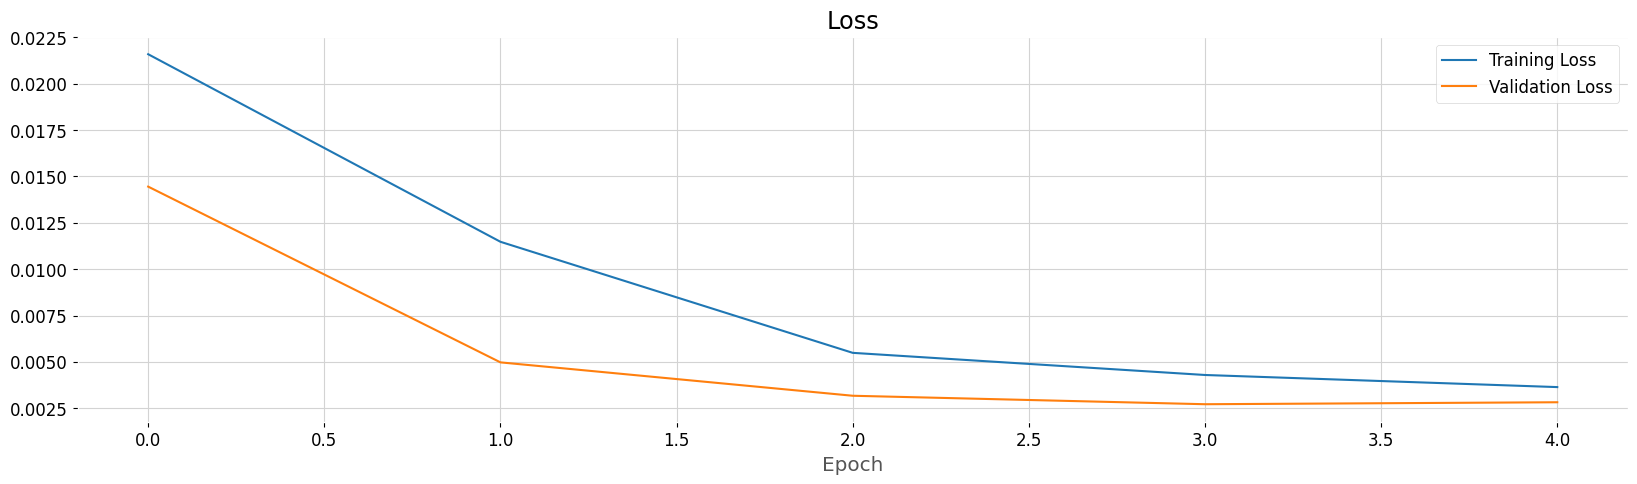

In [48]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')

# Save the plot
plot_path = MODELS_DIR / 'enhanced_new/training_loss_vs_validation_loss.png'
plt.savefig(plot_path)

plt.legend()

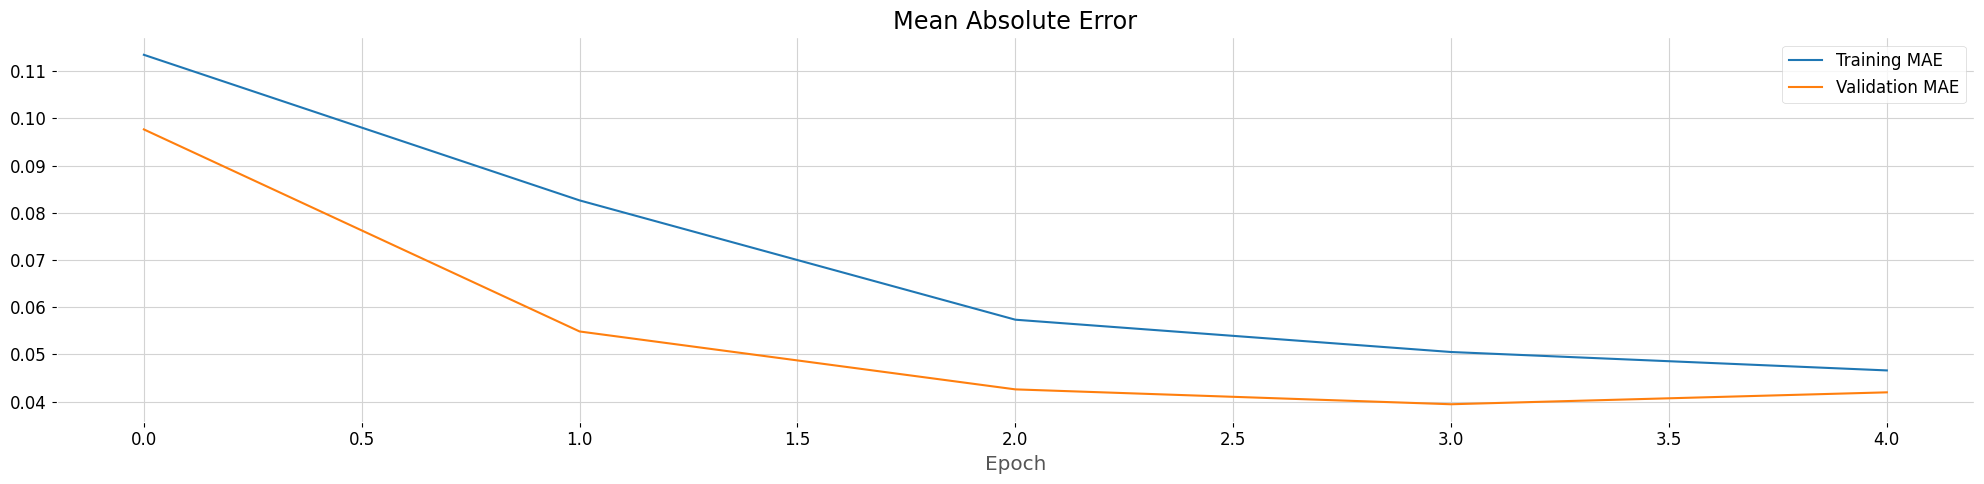

In [49]:
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()

# Save the plot
plot_path = MODELS_DIR / 'enhanced_new/training_mae_vs_validating_mae.png'
plt.savefig(plot_path)

plt.show()

In [50]:
# Evaluate on test set with MAPE
test_loss, test_mae, test_mape = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}%")

2025-04-21 18:07:56.399239: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 41262144 exceeds 10% of free system memory.


 1/88 ━━━━━━━━━━━━━━━━━━━━ 16s 190ms/step - loss: 0.0062 - mean_absolute_error: 0.0686 - mean_absolute_percentage_error: 13.9153

88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - loss: 0.0050 - mean_absolute_error: 0.0564 - mean_absolute_percentage_error: 13.1647
Test Loss: 0.005598059855401516
Test MAE: 0.06034461408853531
Test MAPE: 14.555132865905762%


In [51]:
# Make predictions
y_pred = model.predict(X_test)

2025-04-21 18:08:09.192076: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 41262144 exceeds 10% of free system memory.


88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step


In [52]:
# Inverse transform predictions and actual values
y_test_original = scalers['demand'].inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
y_pred_original = scalers['demand'].inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

# Calculate metrics on the original scale
mse = mean_squared_error(y_test_original.flatten(), y_pred_original.flatten())
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original.flatten(), y_pred_original.flatten())
r2 = r2_score(y_test_original.flatten(), y_pred_original.flatten())
mape = calculate_mape(y_test_original.flatten(), y_pred_original.flatten())

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 11050.7111
Root Mean Squared Error: 105.1224
Mean Absolute Error: 84.7842
Mean Absolute Percentage Error: 4.80%
R² Score: 0.5535


In [53]:
# Visualize predictions vs actual with better plotting
def plot_prediction_vs_actual(y_true, y_pred, dates, sample_idx=0, title="Electricity Demand Prediction"):
    """Enhanced plotting function with prediction intervals"""
    plt.figure(figsize=(15, 7))
    
    # Plot actual values
    plt.plot(dates, y_true[sample_idx, :, 0], 'b-', linewidth=2, label='Actual')
    
    # Plot predicted values
    plt.plot(dates, y_pred[sample_idx, :, 0], 'r--', linewidth=2, label='Predicted')
    
    # Calculate percentage error for this sample
    sample_mape = calculate_mape(y_true[sample_idx, :, 0], y_pred[sample_idx, :, 0])
    
    plt.title(f'{title} (MAPE: {sample_mape:.2f}%)')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Demand', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add a text box with metrics for this sample
    sample_mae = mean_absolute_error(y_true[sample_idx, :, 0], y_pred[sample_idx, :, 0])
    sample_rmse = np.sqrt(mean_squared_error(y_true[sample_idx, :, 0], y_pred[sample_idx, :, 0]))
    
    plt.figtext(0.15, 0.15, 
                f'Sample MAE: {sample_mae:.2f}\nSample RMSE: {sample_rmse:.2f}\nSample MAPE: {sample_mape:.2f}%',
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return plt


Number of dates: 24


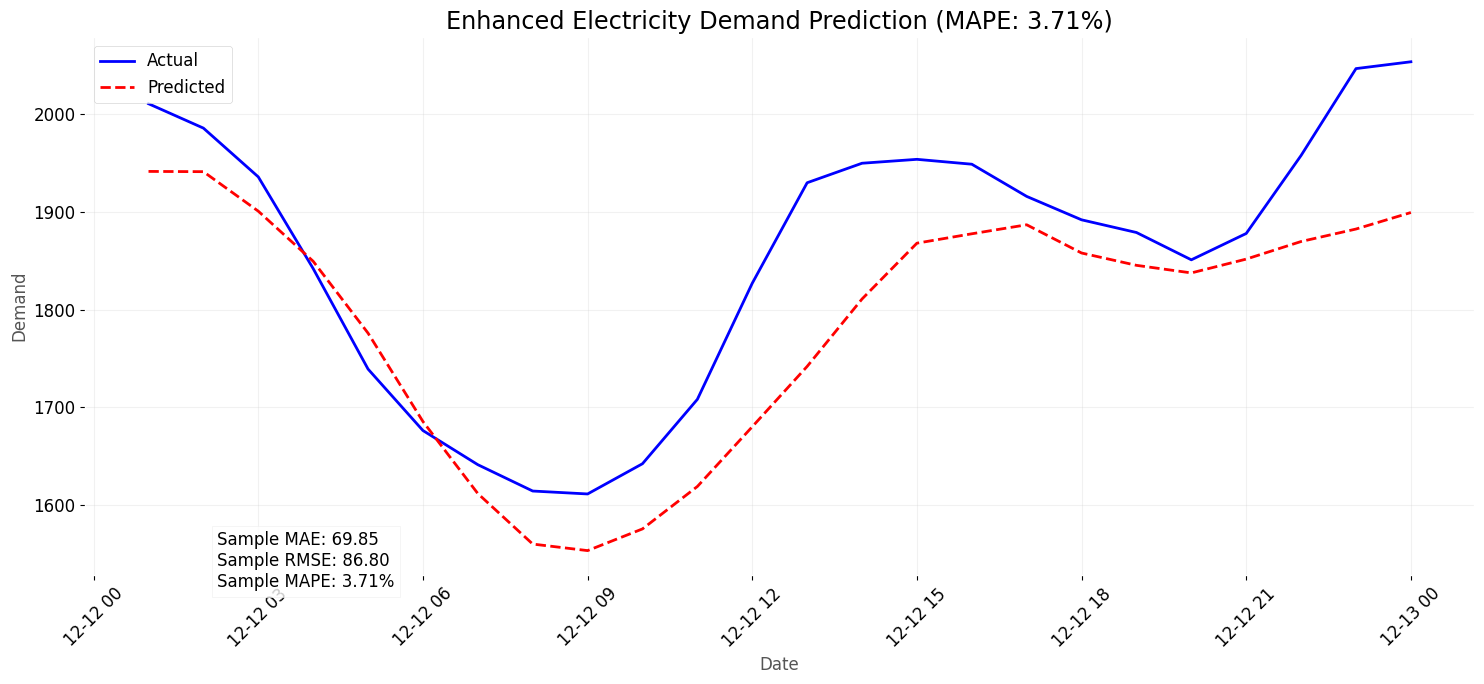

In [54]:
# Plot predictions for a sample
sample_idx = 0  # Choose a sample index

# Use correct input time steps
input_time_steps = 168  # A full week of hourly data
output_time_steps = 24  # Assuming this is your prediction horizon, adjust if different

# Get the actual start index for the test set
test_start_idx = 0  # Start from the beginning of the test set
sample_start_idx = test_start_idx + sample_idx
sample_end_idx = sample_start_idx + output_time_steps

# Ensure indices are within bounds
if sample_end_idx > len(test_set.index):
    print(f"Warning: Sample end index {sample_end_idx} exceeds test set size {len(test_set.index)}")
    # Adjust indices to stay within bounds
    sample_end_idx = len(test_set.index)
    sample_start_idx = max(0, sample_end_idx - output_time_steps)

# Get the corresponding dates
sample_dates = test_set.index[sample_start_idx:sample_end_idx]

# Check if we got valid dates
print(f"Number of dates: {len(sample_dates)}")

# Only proceed if we have dates
if len(sample_dates) > 0:
    plot = plot_prediction_vs_actual(
        y_test_original, 
        y_pred_original, 
        sample_dates, 
        sample_idx=sample_idx,
        title="Enhanced Electricity Demand Prediction"
    )

    # Save the plot
    plot_path = MODELS_DIR / 'enhanced_new/prediction_vs_actual.png'
    plt.savefig(plot_path)

    plt.show()
else:
    print("Error: No valid dates found for plotting")

In [55]:
# Plot predictions for multiple samples to validate model consistency
plt.figure(figsize=(18, 12))

for i in range(4):
    sample_idx = i * 10  # Space out samples
    if sample_idx >= len(y_test_original):
        break
        
    sample_start_idx = len(train_set) + len(val_set) + input_time_steps + sample_idx
    sample_end_idx = sample_start_idx + output_time_steps
    
    if sample_end_idx >= len(test_set):
        continue
        
    sample_dates = test_set.index[sample_start_idx:sample_end_idx]
    
    plt.subplot(2, 2, i+1)
    plt.plot(sample_dates, y_test_original[sample_idx, :, 0], 'b-', label='Actual')
    plt.plot(sample_dates, y_pred_original[sample_idx, :, 0], 'r--', label='Predicted')
    
    sample_mape = calculate_mape(y_test_original[sample_idx, :, 0], y_pred_original[sample_idx, :, 0])
    plt.title(f'Sample {i+1} (MAPE: {sample_mape:.2f}%)')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<Figure size 1800x1200 with 0 Axes>

In [56]:
def evaluate_feature_importance():
    """
    Evaluate feature importance by measuring performance drop when features are removed
    This is a simplified approach - for production, consider more sophisticated methods
    """
    baseline_mae = test_mae
    importance_dict = {}
    
    print("Baseline MAE: ", baseline_mae)
    print("\nFeature Importance Analysis:")
    print("-" * 40)
    
    # Group related features to analyze them together
    feature_groups = {
        'Temperature': [i for i, col in enumerate(feature_cols) if 'temperature' in col],
        'Time - Hour': [i for i, col in enumerate(feature_cols) if 'hour_' in col],
        'Time - Day': [i for i, col in enumerate(feature_cols) if 'day_of_week_' in col],
        'Time - Month': [i for i, col in enumerate(feature_cols) if 'month_' in col],
        'Lag Features': [i for i, col in enumerate(feature_cols) if 'lag_' in col],
        'Rolling Stats': [i for i, col in enumerate(feature_cols) if 'rolling_' in col],
        'Binary Features': [i for i, col in enumerate(feature_cols) if col in ['is_weekend_scaled', 'is_holiday_scaled']]
    }
    
    for group_name, feature_indices in feature_groups.items():
        # Create a modified test set with these features zeroed out
        X_test_modified = X_test.copy()
        X_test_modified[:, :, feature_indices] = 0
        
        # Evaluate on the modified test set
        _, mae_dropped, _ = model.evaluate(X_test_modified, y_test, verbose=0)
        
        # Calculate importance as percentage increase in error
        importance = ((mae_dropped - baseline_mae) / baseline_mae) * 100
        importance_dict[group_name] = importance
        
        print(f"{group_name}: {importance:.2f}% increase in error when removed")
    
    return importance_dict

In [57]:
# Save the final model and artifacts
model.save(MODELS_DIR / 'enhanced_new/enhanced_multifeature_final.keras')

# Save feature column names for inference
with open(MODELS_DIR / 'enhanced_new/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

# Save configuration parameters
config = {
    'input_time_steps': input_time_steps,
    'output_time_steps': output_time_steps,
    'feature_cols': feature_cols,
    'target_col': target_col,
    'binary_features': binary_features
}

with open(MODELS_DIR / 'model_config.pkl', 'wb') as f:
    pickle.dump(config, f)

print("Model and configuration saved successfully!")

Model and configuration saved successfully!


In [53]:
# Example inference function for production deployment
def forecast_demand(model, recent_data, scalers, config):
    """
    Make forecasts using the trained model
    
    Parameters:
    -----------
    model : Keras model
        Trained forecasting model
    recent_data : pandas DataFrame
        Recent data containing required features
    scalers : dict
        Dictionary of feature scalers
    config : dict
        Model configuration parameters
    
    Returns:
    --------
    forecasts : array
        Array of forecasted demand values
    """
    # Prepare input data
    input_steps = config['input_time_steps']
    
    # Ensure we have the right features
    for col in config['feature_cols']:
        if col not in recent_data.columns and not col.endswith('_scaled'):
            base_col = col.replace('_scaled', '')
            if base_col in recent_data.columns:
                # Apply appropriate scaling
                if base_col in scalers:
                    recent_data[col] = scalers[base_col].transform(recent_data[[base_col]])
                else:
                    # For binary features
                    recent_data[col] = recent_data[base_col]
    
    # Create input sequence
    X = recent_data[config['feature_cols']].values
    X = X.reshape(1, X.shape[0], X.shape[1])
    
    # Make prediction
    y_pred = model.predict(X)
    
    # Inverse transform to original scale
    forecasts = scalers['demand'].inverse_transform(y_pred.reshape(-1, 1))
    
    return forecasts.flatten()

In [58]:
import hopsworks

# connect to the project
project = hopsworks.login(
    project=HOPSWORKS_PROJECT_NAME,
    api_key_value=HOPSWORKS_API_KEY
)

# connect to the feature store
feature_store = project.get_feature_store()


2025-04-21 11:21:28,599 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-04-21 11:21:28,603 INFO: Initializing external client
2025-04-21 11:21:28,603 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-04-21 11:21:28,989 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1222815


In [59]:
#in order to save to model for model registoy we have to create scema first
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [60]:
mr = project.get_model_registry()

In [61]:
model_pred = mr.python.create_model(
    name="electricity_demand_predictor_next_24h_enhanced_tr",
    metrics={"test_mae": mae},
    version=2,
    description="Transformer model for next 24-hour power demand prediction",
    input_example=df.sample(),
    model_schema=model_schema
)

# Save the model by pointing to the directory containing all artifacts
model_pred.save(str(MODELS_DIR / 'enhanced_new'))

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /teamspace/studios/this_studio/models/enhanced_new/enhanced_multifeature_final.keras: 0.000%|       …

Uploading /teamspace/studios/this_studio/models/enhanced_new/enhanced_multifeature_model.keras: 0.000%|       …

Uploading /teamspace/studios/this_studio/models/enhanced_new/feature_columns.pkl: 0.000%|          | 0/299 ela…

Uploading /teamspace/studios/this_studio/models/enhanced_new/feature_scalers.pkl: 0.000%|          | 0/6022 el…

Uploading /teamspace/studios/this_studio/models/enhanced_new/logs/train/events.out.tfevents.1745148358.ip-10-1…

Uploading /teamspace/studios/this_studio/models/enhanced_new/logs/train/events.out.tfevents.1745148422.ip-10-1…

Uploading /teamspace/studios/this_studio/models/enhanced_new/logs/train/events.out.tfevents.1745232465.ip-10-1…

Uploading /teamspace/studios/this_studio/models/enhanced_new/logs/validation/events.out.tfevents.1745148726.ip…

Uploading /teamspace/studios/this_studio/models/enhanced_new/logs/validation/events.out.tfevents.1745232785.ip…

Uploading /teamspace/studios/this_studio/input_example.json: 0.000%|          | 0/193 elapsed<00:00 remaining<…

Uploading /teamspace/studios/this_studio/model_schema.json: 0.000%|          | 0/227 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1222815/models/electricity_demand_predictor_next_24h_enhanced_tr/1


Model(name: 'electricity_demand_predictor_next_24h_enhanced_tr', version: 1)